# Debiasing italian word embeddings

### Downlaod data 
First of all, you need to download the Italian Twitter Embeddings pretraned from the following link [here](https://drive.google.com/file/d/15L4NM0NpxSNF6QAjp-E83P_MgA5TkKHl/view?usp=sharing) and insert the file into the `embeddings` folder.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import scipy

import debiaswe.we as we
import debiaswe.metrics as metrics
from debiaswe.we import WordEmbedding
from gensim.models import KeyedVectors

## 1. Analysis of the embeddings

In [2]:
# load the word embeddings
embeddings = WordEmbedding('./embeddings/filtered_twitter128.tsv')

*** Reading data from ./embeddings/filtered_twitter128.tsv
(327168, 128)
327168 words of dimension 128 : di, che, e, a, ..., onqew, leadershipnon, yzibykeju, sbaraglliato


### 1.1 Exploit relations between words computing analogies
Analogies are a useful way to both evaluate the quality of a word embedding and also its stereotypes. In the standard analogy tasks, we are given three words, for example `he`, `she`, `king`, and look for the 4th word to solve  `he : king = she : x`.

In [3]:
# convert WordEmbedding into word2vec format
tmp_file='./embeddings/filtered_twitter_w2v.bin'
embeddings.save_w2v(tmp_file)
w2v_embeddings = KeyedVectors.load_word2vec_format(tmp_file, binary=True)

In [4]:
# fair analogies examples
print("uomo : re = donna : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['donna', 're'], negative=['uomo'], topn=3)])

print("\nmilan : italia = chelsea : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['chelsea', 'italia'], negative=['milan'], topn=3)])

uomo : re = donna : x
Analogy solution x =  [('regina', '63.93%'), ('diva', '58.28%'), ('reginetta', '51.03%')]

milan : italia = chelsea : x
Analogy solution x =  [('inghilterra', '78.54%'), ('america', '77.16%'), ('australia', '70.71%')]


In [5]:
print("uomo : informatica = donna : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['studentessa', 'matematica'], negative=['studente'], topn=10)])


uomo : informatica = donna : x
Analogy solution x =  [('biologia', '68.3%'), ('mate', '66.65%'), ('algebra', '66.23%'), ('grammatica', '65.42%'), ('geostoria', '65.2%'), ('chimica', '65.01%'), ('filosofia', '64.17%'), ('geometria', '63.25%'), ('professoressa', '61.94%'), ('geografia', '61.59%')]


In [28]:
# biased analogies examples
print("uomo : informatica = donna : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['donna', 'informatica'], negative=['uomo'], topn=3)])

print("\nuomo : x = donna : psicologia")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['uomo', 'psicologia'], negative=['donna'], topn=3)])

print("\nstudente : matematica = studentessa : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['studentessa', 'matematica'], negative=['studente'], topn=3)])


print("\nlui : x = lei : filologia")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings.most_similar(positive=['lui', 'filologia'], negative=['lei'], topn=3)])

uomo : informatica = donna : x
Analogy solution x =  [('psicologia', '61.4%'), ('specializzazione', '59.94%'), ('studentessa', '59.55%')]

uomo : x = donna : psicologia
Analogy solution x =  [('anatomia', '65.81%'), ('antropologia', '65.76%'), ('elettromagnetismo', '64.03%')]

studente : matematica = studentessa : x
Analogy solution x =  [('biologia', '68.3%'), ('mate', '66.65%'), ('algebra', '66.23%')]

lui : x = lei : filologia
Analogy solution x =  [('microeconomia', '66.55%'), ('filosofia', '62.4%'), ('macroeconomia', '62.29%')]


## 2. Degree classes stereotypes
This experiment investigates gender representation for 30 different degree classes in the Italian university system in the twitter word embeddings.
For each degree class, we compute its *gender score*. 

### 2.1 Define gender direction

We define gender direction by the pricipal component of 6 directions extracted from specific gender definitional pairs that largely captures gender in the embedding: `[lui (he), lei (she)], [uomo (man), donna (woman)], [padre (father), madre (mother)], [marito (husband), moglie (wife)], [fratello (brother), sorella (sister)], [maschio (male), femmina (female)]`. This direction helps us to quantify direct and indirect biases in words and associations.

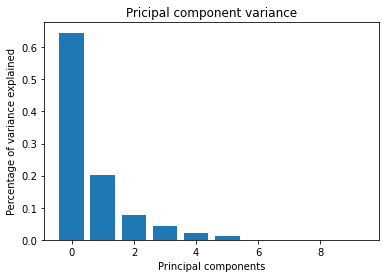

In [7]:
# compute gender direction
female_definitional = ["lei", "donna", "madre", "moglie", "sorella", "femmina"]
male_definitional = ["lui", "uomo", "padre", "marito", "fratello", "maschio"]
gender_definitional_pairs = list(zip(male_definitional, female_definitional))

pca = we.doPCA(gender_definitional_pairs, embeddings)
gender_direction = pca.components_[0]

# plot variance
plt.bar(range(10), pca.explained_variance_ratio_)
plt.title("Pricipal component variance")
plt.xlabel("Principal components")
plt.ylabel("Percentage of variance explained")
plt.show()

### 2.2 Gender bias correlation in degree classes
We compute Pearson’s correlation between the gender scores and the percentage of males enrolled in each degree class during the academic year 2020/21. The data about the gender of students enrolled for each degree class are provided by the [MIUR opendata website](http://ustat.miur.it/).

In [ ]:
# read the dataset about the gender distrubution in italian degree classes
data = pd.read_csv("./data/degree_classes.csv", delimiter=";", encoding='latin-1')
data = data[data['AnnoA'] == '2020/2021']
data = data.pivot_table(columns=['SESSO'], index=['ClasseNOME'], values ='Isc', fill_value=0, aggfunc=sum)
data = pd.DataFrame(np.hstack([np.array(data.index).reshape(-1, 1), data.values]), columns=['ClasseNOME', 'F', 'M'])

# read the aliases of the interesting degree classes
degree_class_aliases = json.load(open("./data/degree_classes_aliases.json", "r"))
degree_class_names = degree_class_aliases.values()

# keep only interesing degree classes
gender_degree_classes = data[data['ClasseNOME'].isin(degree_class_aliases.keys())]
gender_degree_classes['ClasseNOME'] = gender_degree_classes['ClasseNOME'].map(degree_class_aliases)

# change the counts to percentage
total = gender_degree_classes['F']+gender_degree_classes['M']
gender_degree_classes['F'] = gender_degree_classes['F']/(total)
gender_degree_classes['M'] = gender_degree_classes['M']/(total)

In [9]:
gender_degree_classes.sort_values(by='F')

,ClasseNOME,F,M
34,automazione,0.161376,0.838624
26,informatica,0.162022,0.837978
39,elettronica,0.16318,0.83682
28,aerospaziale,0.182731,0.817269
42,industriale,0.234395,0.765605
37,telecomunicazioni,0.263869,0.736131
24,fisica,0.271238,0.728762
114,agraria,0.28292,0.71708
31,ingegneria,0.28956,0.71044
23,finanza,0.316045,0.683955


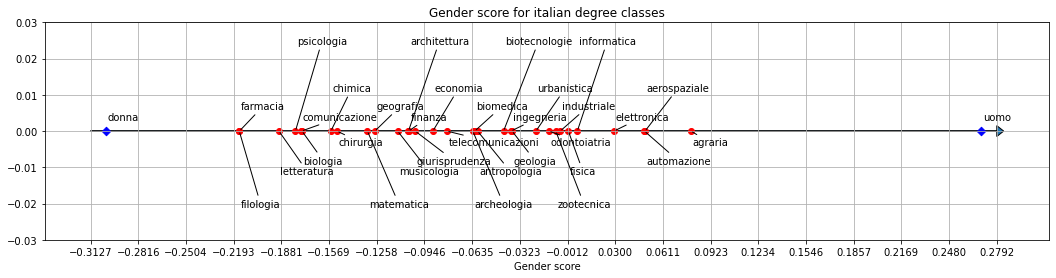

In [10]:
# compute gender score for each neutral word
gender_scores = {w : embeddings.v(w).dot(gender_direction) for w in degree_class_names}
gender_scores = dict(sorted(gender_scores.items(), key=lambda item: item[1]))

# compute the gender score for the gender definitionals
gender_definitional_score = {w : embeddings.v(w).dot(gender_direction) for w in ["uomo","donna"]}

plt.figure(figsize=(18,4))
plt.arrow(gender_definitional_score["donna"]-0.01, 0.0, gender_definitional_score["uomo"]-gender_definitional_score["donna"]+0.02, 0, width=0.0002, head_width=0.003)

plt.scatter(gender_scores.values(), np.zeros(len(gender_scores)), color="red")

y_pos = [-0.021, 0.006, -0.012,  0.024, 0.003, -0.009, 0.011, -0.004]
for i, label in enumerate(gender_scores):
    plt.annotate(label, xy=(gender_scores[label],0), xytext=(gender_scores[label]+0.001, y_pos[i%len(y_pos)]), arrowprops=dict(arrowstyle="-"))

plt.scatter(gender_definitional_score.values(), np.zeros(len(gender_definitional_score)), color="blue", marker="D")
for i, label in enumerate(gender_definitional_score):
    plt.annotate(label, (gender_definitional_score[label]+0.001, 0.003))

plt.xlabel("Gender score")
plt.ylim(-0.03, 0.03)
plt.grid()
plt.title("Gender score for italian degree classes")
plt.xticks(np.linspace(start=gender_definitional_score["donna"]-0.01, stop=gender_definitional_score["uomo"]+0.01, num=20))
plt.show()

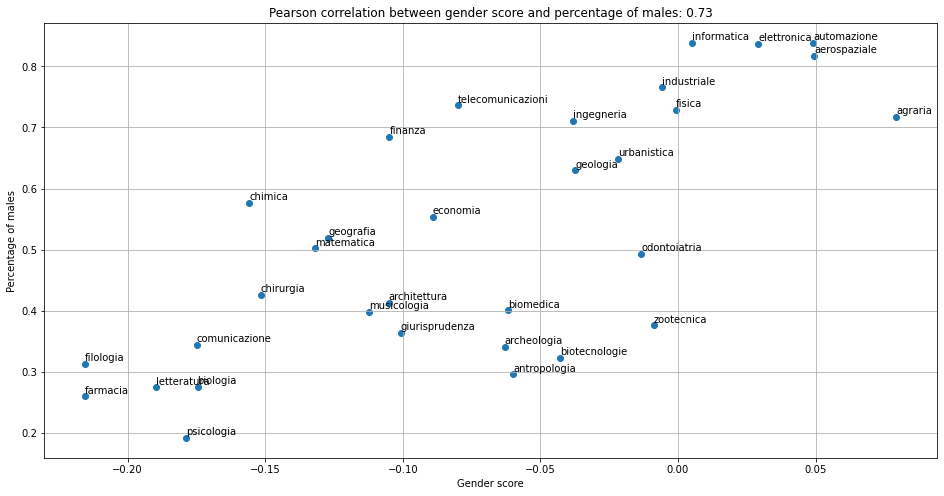

In [11]:
# plot correlation with percentage of males
pairs = np.array([[gender_scores[row['ClasseNOME']], row['M']] for i, row in gender_degree_classes.iterrows()])

plt.figure(figsize=(16,8))
plt.scatter(pairs[:, 0], pairs[:, 1])
for i in range(len(gender_degree_classes)):
    plt.annotate(gender_degree_classes['ClasseNOME'].tolist()[i], (pairs[i, 0], pairs[i, 1] + 0.005))
plt.grid()
plt.xlabel("Gender score")
plt.ylabel("Percentage of males")
plt.title("Pearson correlation between gender score and percentage of males: "+str(round(scipy.stats.pearsonr(pairs[:, 0], pairs[:, 1])[0], 2)))
plt.show()

### 2.3 Metric evaluation

In [12]:
degree_class_embeddings = [embeddings.v(w) for w in degree_class_names]

female_embeddings = [embeddings.v(w) for w in female_definitional]
male_embeddings = [embeddings.v(w) for w in male_definitional]

print("Bias score: ", metrics.bias_score(degree_class_embeddings, male_embeddings, female_embeddings))
print("Skew bias score: ", metrics.skew_bias_score(degree_class_embeddings, male_embeddings, female_embeddings))

Bias score:  0.08919041276661636
Skew bias score:  -0.0751579533525986


## 3. Debiasing

The goals of debiasing are:
1. Reduce bias:

    a. Ensure that gender neutral words such as nurse are equidistant between gender pairs such as he and she. 
    
    b. Reduce gender associations that pervade the embedding even among gender neutral words. 
2. Maintain embedding utility:

    a. Maintain meaningful non-gender-related associations between gender neutral words, including associations within stereotypical categories of words such as fashion-related words or words associated with football.
    
    b. Correctly maintain definitional gender associations such as between man and father.

### 3.1 Hard-debiasing algorithm

In [13]:
# load some gender related word lists to help us with debiasing
with open('./data/equalize_pairs_it.json', "r") as f:
    equalize_pairs = json.load(f)

In [14]:
# hard-debiasing of the embedding, store the old embeddings to not overload
embeddings_deb = embeddings  

# for each word which is not gender specific, remove the gendere direction
for i, w in enumerate(embeddings_deb.words):
    if w in degree_class_names:
        embeddings_deb.vecs[i] = we.drop(embeddings_deb.vecs[i], gender_direction)
embeddings_deb.normalize()

#  recenter the gender specific words with respect to the gender direction
for (a, b) in equalize_pairs:
    if (a in embeddings_deb.index and b in embeddings_deb.index):
        y = we.drop((embeddings_deb.v(a) + embeddings_deb.v(b)) / 2, gender_direction)
        z = np.sqrt(1 - np.linalg.norm(y)**2)
        if (embeddings_deb.v(a) - embeddings_deb.v(b)).dot(gender_direction) < 0:
            z = -z
        embeddings_deb.vecs[embeddings_deb.index[a]] = z * gender_direction + y
        embeddings_deb.vecs[embeddings_deb.index[b]] = -z * gender_direction + y
embeddings_deb.normalize()

327168 words of dimension 128 : di, che, e, a, ..., onqew, leadershipnon, yzibykeju, sbaraglliato
327168 words of dimension 128 : di, che, e, a, ..., onqew, leadershipnon, yzibykeju, sbaraglliato


In [15]:
# recompute the gender direction
pca_deb = we.doPCA(gender_definitional_pairs, embeddings_deb)
gender_direction_deb = pca_deb.components_[0]

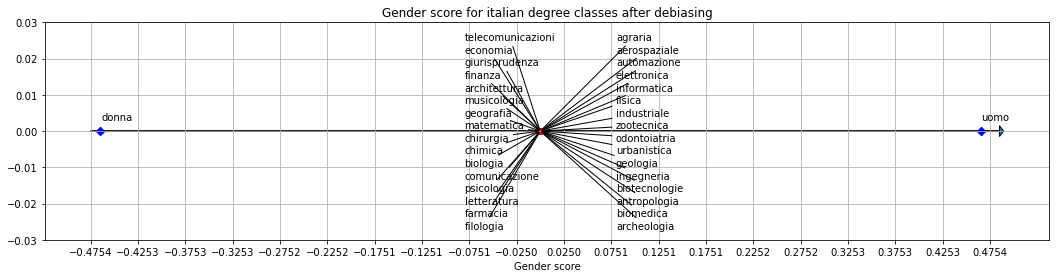

In [16]:
# compute gender score for each neutral word after debiasing
gender_scores_deb = {w : embeddings_deb.v(w).dot(gender_direction_deb) for w in degree_class_names}
gender_scores_deb = dict(sorted(gender_scores_deb.items(), key=lambda item: item[1]))

# compute the gender score for the gender definitionals
gender_definitional_score_deb = {w : embeddings_deb.v(w).dot(gender_direction_deb) for w in ["uomo","donna"]}

plt.figure(figsize=(18,4))
plt.arrow(gender_definitional_score_deb["donna"]-0.01, 0.0, gender_definitional_score_deb["uomo"]-gender_definitional_score_deb["donna"]+0.03, 0, width=0.0002, head_width=0.003)

plt.scatter(gender_scores_deb.values(), np.zeros(len(gender_scores_deb)), color="red")

y_pos_deb = np.linspace(start=-0.027, stop=0.025, num=16)
for i, label in enumerate(gender_scores):
    x_pos = -0.08 if i < len(gender_scores)/2 else +0.08
    plt.annotate(label, xy=(gender_scores_deb[label],0), xytext=(gender_scores_deb[label]+x_pos, y_pos_deb[i%len(y_pos_deb)]), arrowprops=dict(arrowstyle="-"))

plt.scatter(gender_definitional_score_deb.values(), np.zeros(len(gender_definitional_score_deb)), color="blue", marker="D")
for i, label in enumerate(gender_definitional_score_deb):
    plt.annotate(label, (gender_definitional_score_deb[label]+0.001, 0.003))

plt.xlabel("Gender score")
plt.ylim(-0.03, 0.03)
plt.grid()
plt.title("Gender score for italian degree classes after debiasing")
plt.xticks(np.linspace(start=gender_definitional_score_deb["donna"]-0.01, stop=gender_definitional_score_deb["uomo"]+0.01, num=20))
plt.show()

### 3.2 Analogies post-debiasing

In [ ]:
# convert WordEmbedding into word2vec format
tmp_file='./embeddings/twitter_w2v_debiased.bin'
embeddings_deb.save_w2v(tmp_file)
w2v_embeddings_deb = KeyedVectors.load_word2vec_format(tmp_file, binary=True)

In [18]:
# fair analogies examples
print("uomo : re = donna : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings_deb.most_similar(positive=['donna', 're'], negative=['uomo'], topn=3)])

print("\nmilan : italia = chelsea : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings_deb.most_similar(positive=['chelsea', 'italia'], negative=['milan'], topn=3)])

uomo : re = donna : x
Analogy solution x =  [('regina', '64.92%'), ('orologiaia', '58.87%'), ('maestà', '58.49%')]

milan : italia = chelsea : x
Analogy solution x =  [('inghilterra', '78.54%'), ('america', '77.16%'), ('australia', '70.71%')]


In [29]:
# biased analogies after debiasing
print("uomo : informatica = donna : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings_deb.most_similar(positive=['donna', 'informatica'], negative=['uomo'], topn=3)])

print("\ndonna : psicologia = uomo : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings_deb.most_similar(positive=['uomo', 'psicologia'], negative=['donna'], topn=3)])


print("\nstudente : matematica = studentessa : x")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings_deb.most_similar(positive=['studentessa', 'matematica'], negative=['studente'], topn=3)])


print("\nlui : x = lei : filologia")
print("Analogy solution x = ", [(x[0], str(round(x[1]*100,2))+"%") for x in w2v_embeddings_deb.most_similar(positive=['lui', 'filologia'], negative=['lei'], topn=3)])

uomo : informatica = donna : x
Analogy solution x =  [('programmatrice', '66.78%'), ('meccanica', '65.06%'), ('impiegata', '63.9%')]

donna : psicologia = uomo : x
Analogy solution x =  [('psicologo', '67.68%'), ('formatore', '63.31%'), ('meccanico', '63.28%')]

studente : matematica = studentessa : x
Analogy solution x =  [('algebra', '68.04%'), ('mate', '67.96%'), ('geostoria', '66.2%')]

lui : x = lei : filologia
Analogy solution x =  [('letteratura', '64.3%'), ('microeconomia', '64.03%'), ('psicologia', '62.53%')]


### 3.3 Metric evaluation post-debiasing 

In [20]:
degree_class_embeddings_deb = [embeddings_deb.v(w) for w in degree_class_names]

female_embeddings_deb = [embeddings_deb.v(w) for w in female_definitional]
male_embeddings_deb = [embeddings_deb.v(w) for w in male_definitional]

print("Bias score: ", metrics.bias_score(degree_class_embeddings_deb, male_embeddings_deb, female_embeddings_deb))
print("Skew bias score: ", metrics.skew_bias_score(degree_class_embeddings_deb, male_embeddings_deb, female_embeddings_deb))

Bias score:  1.2112149220507601e-08
Skew bias score:  6.6258922904685745e-09
